<h3>Import libraries</h3>


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import gensim 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

1.5.0


<h3>Load data</h3>

In [4]:
#path_data = '../../yelp_academic_dataset_review.pickle'
#data = pd.read_pickle(path_data)

In [5]:
# Removing all ('\n') characters using list comprehensions
#data['text'] = [txt.replace('\n', '') for txt in data['text']]

# Taking only text and stars columns
#data = data.loc[:, ['text', 'stars']]

In [6]:
#data.head()

<h3>Tokenizer</h3>

Tokenizing sentences to a list of separate words

In [7]:
#data["tokens"] = data.apply(lambda row: word_tokenize(row["text"]), axis=1)

#data.head()

<h3>Checkpoint</h3>

In [8]:
#data.to_csv("data_with_tokens.csv", index=False)

In [9]:
data = pd.read_csv("data_with_tokens.csv")


In [10]:
data=data.dropna()

<h3>Bag of Words Counts</h3>


&nbsp;&nbsp;&nbsp;A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence in our dataset, and then use these embeddings to accurately predict the relevant category.<br><br>
&nbsp;&nbsp;&nbsp;The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.


In [11]:
def count_vectorize(data):
    count_vectorizer = CountVectorizer()
    
    embedding = count_vectorizer.fit_transform(data)
    
    return embedding, count_vectorizer

X = data["text"].tolist()
y = data["stars"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = count_vectorize(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [12]:
X_train_counts

<1255410x389905 sparse matrix of type '<class 'numpy.int64'>'
	with 98667654 stored elements in Compressed Sparse Row format>

<h3>Load word2vec model</h3>

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. <br>
Download link at : <a href="https://code.google.com/archive/p/word2vec/">Pre-trained word2vec</a> (section <b>Pre-trained word and phrase vectors</b>)

In [13]:
PATH_WORD2VEC = "../../GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(PATH_WORD2VEC, binary=True,limit=500000)

<h3>CNNs for text classification</h3>


Here, we will be using a Convolutional Neural Network for sentence classification. While not as popular as RNNs, they have been proven to get competitive results (sometimes beating the best models), and are very fast to train.<br>

This idea originally comes from the following paper from Yoon Kim, <b>Convolutional Neural Networks Networks for Sentence Classification</b>; https://arxiv.org/abs/1408.5882

First we need to embed our text



In [14]:
all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
vocabulary = sorted(list(set(all_words)))

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(vocabulary)
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(data["text"].tolist())
sequences = tokenizer.texts_to_sequences(data["text"].tolist())

word_index = tokenizer.word_index
print("Found %s unique tokens." % (len(word_index)))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(data["stars"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, index in word_index.items():
    embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print("embedding_weights shape: ", embedding_weights.shape)

Found 492840 unique tokens.
embedding_weights shape:  (492841, 300)


In [15]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, trainable=False):
    
    embedding_layer = Embedding(num_words, \
                                embedding_dim, \
                                weights=[embeddings], \
                                input_length=max_sequence_length, \
                                trainable=trainable)
    
    sequence_input = Input(shape=(max_sequence_length, ), dtype="int32", name="Input")
    embedded_sequences = embedding_layer(sequence_input)
    
    convs = []
    filter_sizes = [3, 4, 5]
    
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)
    
    l_merge = Merge(mode='concat', concat_axis=1, name="Merge")(convs)
    
    l_conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(pool_size=3)(l_conv1)
    
    l_drop  = Dropout(0.5)(l_pool1)
    
    l_flat  = Flatten(name="Flatten")(l_drop)
    
    l_dense = Dense(128, activation='relu', name="Dense")(l_flat)
    
    
    preds = Dense(6, activation='softmax', name="Output")(l_dense)
    
    model = Model(sequence_input, preds)
    
    return model

In [28]:
X_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val  = cnn_data[-num_validation_samples:]
y_val  = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, \
                MAX_SEQUENCE_LENGTH, \
                len(word_index)+1, \
                EMBEDDING_DIM, \
                trainable=False)

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 300)      147852300   Input[0][0]                      
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 33, 128)      115328      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 32, 128)      153728      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_11 

<h3>Training the model</h3>

In [31]:
model.compile(loss='categorical_crossentropy', \
              optimizer='adam', \
              metrics=['acc'])

In [32]:
from keras.callbacks import ModelCheckpoint

In [33]:
## Create checkpoint that saves the weights each time validation set at each epoch is outperformed by the last one
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, \
                             monitor="val_acc", \
                             verbose=1, \
                             save_best_only=True, \
                             mode="max")
callbacks_list = [checkpoint]

In [34]:
history = model.fit(X_train, y_train, \
                    validation_data=(X_val, y_val), \
                    epochs=10, \
                    batch_size=512, \
                    callbacks=callbacks_list, \
                    verbose=1)

Train on 1255411 samples, validate on 313852 samples
Epoch 1/10
1255411/1255411 [==============================] - 2232s 2ms/step - loss: 1.0678 - acc: 0.5319 - val_loss: 0.9890 - val_acc: 0.5670

Epoch 00001: val_acc improved from -inf to 0.56700, saving model to weights_best.hdf5
Epoch 2/10
1255411/1255411 [==============================] - 2206s 2ms/step - loss: 0.9823 - acc: 0.5697 - val_loss: 0.9788 - val_acc: 0.5707

Epoch 00002: val_acc improved from 0.56700 to 0.57071, saving model to weights_best.hdf5
Epoch 3/10
1255411/1255411 [==============================] - 2193s 2ms/step - loss: 0.9581 - acc: 0.5802 - val_loss: 0.9596 - val_acc: 0.5795

Epoch 00003: val_acc improved from 0.57071 to 0.57949, saving model to weights_best.hdf5
Epoch 4/10
1255411/1255411 [==============================] - 2192s 2ms/step - loss: 0.9428 - acc: 0.5868 - val_loss: 0.9661 - val_acc: 0.5775

Epoch 00004: val_acc did not improve
Epoch 5/10
1255411/1255411 [==============================] - 2194s 2m

In [35]:
# Serialize model to JSON

model_json = model.to_json()
with open("model_convnet.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5

model.save_weights("model_convnet.h5")
print("Saved model to disk")

Saved model to disk


<h3>Plotting the training and validation loss</h3>

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

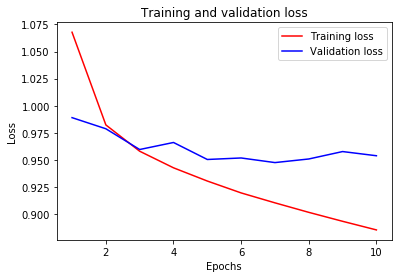

In [42]:
history_dict = history.history
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

num_epochs = 10
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss_values, 'r', label="Training loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

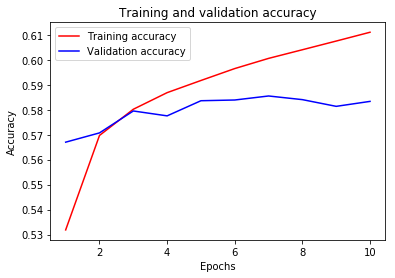

In [43]:
history_dict = history.history
train_acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

num_epochs = 10
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_acc_values, 'r', label="Training accuracy")
plt.plot(epochs, val_acc_values, 'b', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

<h3>Evaluate model</h3>

In [44]:
## Evaluate model directly without loading json and hdf5 files
scores = model.evaluate(X_test, y_test)
print("%s on test data: %.2f%%" % (model.metrics_names[1], scores[1]*100))

AttributeError: 'str' object has no attribute 'ndim'

In [46]:
## Evaluate model directly without loading json and hdf5 files
scores = model.evaluate(X_test_counts, y_test)
print("%s on test data: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ValueError: Error when checking input: expected Input to have shape (35,) but got array with shape (389905,)

In [ ]:

sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

test_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = to_categorical(y_test)

indices = np.arange(test_data.shape[0])
np.random.shuffle(indices)
test_data = test_data[indices]
labels_test = labels_test[indices]

